In [30]:
import mido
from mido import MidiFile, MidiTrack, Message, MetaMessage, bpm2tempo, tempo2bpm
import numpy as np
import matplotlib.pyplot as plt
from midi_player import MIDIPlayer
import os
import torch
import torch.nn as nn
import torch.functional as F
from midi_tools import midi_to_tensor, tensor_to_midi

In [2]:
# TODO: Create the midi parser.
# Following https://arxiv.org/pdf/1808.03715 - 5.0.1

In [20]:
# midi_path = './_adl-piano-midi/midi/adl-piano-midi/Classical/Classical Flute/James Galway/Hero.mid'
# midi_path = './_adl-piano-midi/midi/adl-piano-midi/Folk/Alpine Yodeling/Jacob Sisters/La-La-La.mid'
# midi_path = './_google_maestro_v3/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi'
midi_path = './_google_maestro_v3/2018/MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--3.midi'

In [ ]:
instructions, ppq, tempo = midi_to_tensor(midi_path, max_length=64000)
out_midi = tensor_to_midi(instructions, ppq, tempo, 'test.mid')

In [8]:
MIDIPlayer('test.mid', 400)

In [9]:
MIDIPlayer(midi_path, 400)

In [14]:
token_lengths = []
for dir_path, _, filenames in os.walk('./_google_maestro_v3/'):
    for file in filenames:
        if not file.endswith('.midi'):
            continue
        midi_path = os.path.join(dir_path, file)
        midi_tokens, _, _ = midi_to_tensor(midi_path)
        token_lengths.append(len(midi_tokens))

In [15]:
print('max:', max(token_lengths))
print('min:', min(token_lengths))
print('mean:', sum(token_lengths) / len(token_lengths))
print('std:', np.std(token_lengths))

max: 107062
min: 624
mean: 24200.134012539183
std: 18344.125452130826


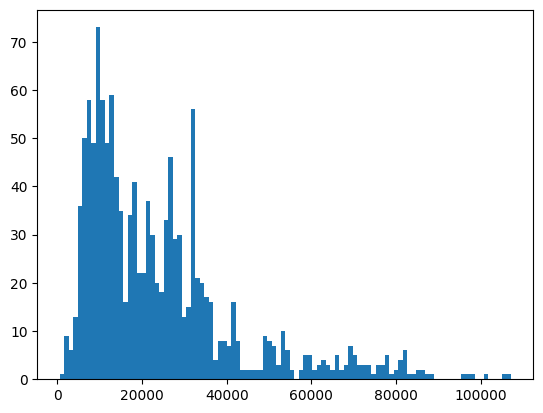

In [27]:
# Histogram of token lengths
plt.hist(token_lengths, bins=100)
plt.show()

In [23]:
num_tracks = []
for dir_path, _, filenames in os.walk('./_google_maestro_v3/'):
    for file in filenames:
        if not file.endswith('.midi'):
            continue
        midi_path = os.path.join(dir_path, file)
        num_tracks.append(len(mido.MidiFile(midi_path).tracks))

In [25]:
print('max:', max(num_tracks))
print('min:', min(num_tracks))
print('mean:', sum(num_tracks) / len(num_tracks))
print('std:', np.std(num_tracks))

max: 2
min: 2
mean: 2.0
std: 0.0


In [22]:
instructions.shape

torch.Size([13843])

In [40]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
class TokenAndPositionEmbedding(nn.Module):

    def __init__(self, max_length, vocab_size, embed_dim):
        super().__init__()
        self.max_length = max_length
        self.token_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.position_embedding = nn.Embedding(num_embeddings=max_length, embedding_dim=embed_dim)

    def forward(self, x):
        positions = torch.arange(start=0, end=self.max_length, step=1).to(DEVICE)
        position_embedding = self.position_embedding(positions)
        token_embedding = self.token_embedding(x)
        return token_embedding + position_embedding

In [42]:
class TransformerBlock(nn.Module):

    def __init__(self,
                 max_length,
                 num_heads,
                 key_dim,
                 embd_dim,
                 ff_dim,
                 dropout_rate=0.1
                 ):
        super().__init__()

        self.attention_mask = torch.tril(torch.ones(max_length, max_length)).bool().to(DEVICE)

        self.attention = nn.MultiheadAttention(
            embed_dim=embd_dim,
            num_heads=num_heads,
            kdim=key_dim,
            vdim=key_dim,
            batch_first=True
            )
        self.dropout1 = nn.Dropout(dropout_rate)
        self.norm1 = nn.LayerNorm(embd_dim, eps=1e-6)
        self.ffn_1 = nn.Linear(embd_dim, ff_dim)
        self.ffn_2 = nn.Linear(ff_dim, embd_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.norm2 = nn.LayerNorm(embd_dim, eps=1e-6)

    def forward(self, batch):
        attention_output, _ = self.attention(batch, batch, batch, attn_mask=self.attention_mask)
        attention_output = self.dropout1(attention_output)
        attention_output = self.norm1(attention_output + batch)
        ffn_output = F.relu(self.ffn_1(attention_output))
        ffn_output = self.ffn_2(ffn_output)
        ffn_output = self.dropout2(ffn_output)
        ffn_output = self.norm2(ffn_output + attention_output)
        return ffn_output

In [43]:
class MidiGPT(nn.Module):
    def __init__(
            self,
            max_length: int,
            vocab_size: int,
            embed_dim: int,
            feed_forward_dim: int,
            num_heads: int,
            key_dim: int,
        ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(max_length, num_heads, key_dim, embed_dim, feed_forward_dim)
        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, batch):
        embedding = self.embedding_layer(batch)
        transformer_output = self.transformer_block(embedding)
        output = self.output_layer(transformer_output)
        return output